In [2]:
"""
Project: Identification of U.S Counties Based on Similar Health Profiles
Dataset: 2025 County Health Rankings from countyhealthrankings.org
Overview: Use of unsupervised learning and clustering to group over 3,000 counties into health-risk profiles
          to identify regional and national patterns.
Author: Josue Aguilar
"""

import pandas as pd 
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Skip header while loading dataset
PATH = "data/2025_county_health_data.csv"
full_county_data =  pd.read_csv(PATH, skiprows=[0])

In [4]:
# Features from the dataset that define a health profile
county_data = full_county_data[["FIPS",
                                "State",
                                "County",
                                "% Children in Poverty",
                                "% Fair or Poor Health",
                                "% Low Birth Weight",
                                "% With Access to Exercise Opportunities",
                                "% Long Commute - Drives Alone",
                                "% Uninsured",
                                "% Completed High School",
                                "% Some College",
                                "% Severe Housing Problems",
                                "% Unemployed",
                                "Average Number of Physically Unhealthy Days",
                                "Average Number of Mentally Unhealthy Days",
                                "Years of Potential Life Lost Rate",
                                "Average Daily PM2.5",
                                "Food Environment Index",
                                "Primary Care Physicians Rate",
                                "Dentist Rate",
                                "Mental Health Provider Rate",
                                "Income Ratio",
                                "Presence of Water Violation",
                               ]].copy()

In [5]:
county_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3210 entries, 0 to 3209
Data columns (total 23 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   FIPS                                         3210 non-null   int64  
 1   State                                        3210 non-null   object 
 2   County                                       3159 non-null   object 
 3   % Children in Poverty                        3194 non-null   float64
 4   % Fair or Poor Health                        3195 non-null   float64
 5   % Low Birth Weight                           3094 non-null   float64
 6   % With Access to Exercise Opportunities      3148 non-null   float64
 7   % Long Commute - Drives Alone                3195 non-null   float64
 8   % Uninsured                                  3194 non-null   float64
 9   % Completed High School                      3195 non-null   float64
 10  

In [6]:
# Removing data points that are not counties. States are included within the dataset.
county_data = county_data.dropna(subset=["County"])

In [7]:
county_data.head()

,FIPS,State,County,% Children in Poverty,% Fair or Poor Health,% Low Birth Weight,% With Access to Exercise Opportunities,% Long Commute - Drives Alone,% Uninsured,% Completed High School,...,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,Years of Potential Life Lost Rate,Average Daily PM2.5,Food Environment Index,Primary Care Physicians Rate,Dentist Rate,Mental Health Provider Rate,Income Ratio,Presence of Water Violation
1,1001,Alabama,Autauga,17.0,18.0,10.0,54.0,42.0,8.0,90.0,...,4.3,5.8,9938.0,9.3,6.8,44.0,30.0,36.0,4.3,No
2,1003,Alabama,Baldwin,14.0,17.0,8.0,62.0,38.0,10.0,92.0,...,3.9,6.0,8957.0,7.8,7.4,63.0,47.0,121.0,4.4,No
3,1005,Alabama,Barbour,35.0,28.0,12.0,55.0,38.0,12.0,78.0,...,5.4,6.3,12739.0,8.8,6.2,40.0,32.0,28.0,5.6,No
4,1007,Alabama,Bibb,21.0,25.0,10.0,43.0,54.0,11.0,80.0,...,5.1,6.6,11709.0,8.6,7.3,67.0,23.0,37.0,5.3,Yes
5,1009,Alabama,Blount,17.0,23.0,8.0,42.0,61.0,13.0,83.0,...,4.8,6.4,11898.0,8.8,7.4,20.0,17.0,28.0,4.6,No


In [8]:
# Median imputation prefered to prevent outliers skewing data
county_data = county_data.fillna(county_data.median(numeric_only=True))

In [9]:
county_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3159 entries, 1 to 3209
Data columns (total 23 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   FIPS                                         3159 non-null   int64  
 1   State                                        3159 non-null   object 
 2   County                                       3159 non-null   object 
 3   % Children in Poverty                        3159 non-null   float64
 4   % Fair or Poor Health                        3159 non-null   float64
 5   % Low Birth Weight                           3159 non-null   float64
 6   % With Access to Exercise Opportunities      3159 non-null   float64
 7   % Long Commute - Drives Alone                3159 non-null   float64
 8   % Uninsured                                  3159 non-null   float64
 9   % Completed High School                      3159 non-null   float64
 10  % Som

In [10]:
# Fips is a unique identifer for each county. Identifying duplicates ensures each county entry is unique
county_data["FIPS"].duplicated().sum()

np.int64(0)

In [11]:
county_data["Presence of Water Violation"].unique()

array(['No', 'Yes', nan], dtype=object)

In [12]:
# Missing values for water violations most likely means there is not one allowing nulls to be filled with no
county_data["Presence of Water Violation"] = county_data["Presence of Water Violation"].fillna("No")

In [13]:
county_data["Presence of Water Violation"].unique()

array(['No', 'Yes'], dtype=object)

In [14]:
# Changing categorical water violation into binary for compatibility with model
county_data["Presence of Water Violation"] = county_data["Presence of Water Violation"].map({
    "Yes": 1,
    "No": 0
})

In [15]:
# State and county changed to index to ensure unique labels for models to only work with numeric values
county_data["State_and_County"] = county_data["State"] + ": " + county_data["County"]
county_data.set_index("State_and_County", inplace = True)

In [16]:
# Individual state and county columns no longer needed as they are part of the index
county_data.drop(columns=["State", "County"], inplace = True)

In [17]:
county_data.head()

,FIPS,% Children in Poverty,% Fair or Poor Health,% Low Birth Weight,% With Access to Exercise Opportunities,% Long Commute - Drives Alone,% Uninsured,% Completed High School,% Some College,% Severe Housing Problems,...,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,Years of Potential Life Lost Rate,Average Daily PM2.5,Food Environment Index,Primary Care Physicians Rate,Dentist Rate,Mental Health Provider Rate,Income Ratio,Presence of Water Violation
State_and_County,,,,,,,,,,,,,,,,,,,,,
Alabama: Autauga,1001,17.0,18.0,10.0,54.0,42.0,8.0,90.0,61.0,14.0,...,4.3,5.8,9938.0,9.3,6.8,44.0,30.0,36.0,4.3,0
Alabama: Baldwin,1003,14.0,17.0,8.0,62.0,38.0,10.0,92.0,65.0,12.0,...,3.9,6.0,8957.0,7.8,7.4,63.0,47.0,121.0,4.4,0
Alabama: Barbour,1005,35.0,28.0,12.0,55.0,38.0,12.0,78.0,44.0,14.0,...,5.4,6.3,12739.0,8.8,6.2,40.0,32.0,28.0,5.6,0
Alabama: Bibb,1007,21.0,25.0,10.0,43.0,54.0,11.0,80.0,44.0,12.0,...,5.1,6.6,11709.0,8.6,7.3,67.0,23.0,37.0,5.3,1
Alabama: Blount,1009,17.0,23.0,8.0,42.0,61.0,13.0,83.0,53.0,10.0,...,4.8,6.4,11898.0,8.8,7.4,20.0,17.0,28.0,4.6,0


In [18]:
# Features are standardized to ensure variables are on an equal scale
health_profile = county_data.drop(columns=["FIPS"])
scaler = StandardScaler()
health_profile_scaled = scaler.fit_transform(health_profile)

In [19]:
# Take scaled array from health profile and convert it back into a DataFrame for maintaining index
county_data_scaled = pd.DataFrame(health_profile_scaled, index= county_data.index, columns=health_profile.columns)

In [20]:
county_data_scaled.head()

,% Children in Poverty,% Fair or Poor Health,% Low Birth Weight,% With Access to Exercise Opportunities,% Long Commute - Drives Alone,% Uninsured,% Completed High School,% Some College,% Severe Housing Problems,% Unemployed,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,Years of Potential Life Lost Rate,Average Daily PM2.5,Food Environment Index,Primary Care Physicians Rate,Dentist Rate,Mental Health Provider Rate,Income Ratio,Presence of Water Violation
State_and_County,,,,,,,,,,,,,,,,,,,,
Alabama: Autauga,-0.253242,-0.338100,0.757210,-0.355278,0.686601,-0.530795,0.224776,0.155196,0.268272,-1.140755,-0.237280,0.261413,-0.137970,0.835807,-0.551867,-0.254546,-0.528677,-0.752346,-0.319167,-0.754519
Alabama: Baldwin,-0.626546,-0.546991,-0.189377,-0.002388,0.372576,-0.100520,0.590601,0.497439,-0.183954,-1.058646,-0.841525,0.591141,-0.404795,0.077067,-0.046988,0.275686,-0.031870,-0.375136,-0.195486,-0.754519
Alabama: Barbour,1.986583,1.750808,1.703798,-0.311167,0.372576,0.329755,-1.970177,-1.299339,0.268272,0.665624,1.424396,1.085733,0.623882,0.582894,-1.056745,-0.366174,-0.470229,-0.787848,1.288686,-0.754519
Alabama: Bibb,0.244497,1.124136,0.757210,-0.840502,1.628677,0.114617,-1.604351,-1.299339,-0.183954,-0.894430,0.971212,1.580325,0.343730,0.481728,-0.131134,0.387314,-0.733244,-0.747908,0.917643,1.325347
Alabama: Blount,-0.253242,0.706354,-0.189377,-0.884614,2.178221,0.544892,-1.055613,-0.529291,-0.636180,-1.222863,0.518027,1.250597,0.395136,0.582894,-0.046988,-0.924312,-0.908588,-0.787848,0.051876,-0.754519


# Analysis Part 1: Cosine Section

In [21]:
def calculating_cosine(county_of_interest):
    """
    Calculates Cosine Distance with a county input to find top 10 similar counties
    """

    # Calculates distance while excluding the county of interest from results
    cosine_distances = pairwise_distances(county_data_scaled, county_data_scaled.loc
                                          [[county_of_interest]], metric="cosine")[:,0]

    cosine_pairs = [(county,distance) for county, distance in zip(county_data_scaled.index, cosine_distances) 
                    if county != county_of_interest]

    top_counties = sorted(cosine_pairs, key=lambda x: x[1])[:10]
    print(f"Top 10 Counties most similar to {county_of_interest} using Cosine Distance")

    for county, distance in top_counties:
        print(f"{county} = {distance}")

Data Validation:
The following Underperforming counties were tested for similarities. These counties were identified by using the County Health Rankings map of counties underperforming based on key health outcomes. The counties Fresno (CA), Franklin (LA), and Robeson (NC) were chosen to better understand systemic challenges faced across the United States.

In [22]:
calculating_cosine('California: Fresno')

Top 10 Counties most similar to California: Fresno using Cosine Distance
California: Sutter = 0.04453119059670474
California: Kern = 0.050356389113811684
California: Tulare = 0.0693361202007653
California: Kings = 0.08683399289327476
California: Glenn = 0.09728393845036853
California: Yuba = 0.10015514141626758
Oregon: Klamath = 0.10636444558118185
California: Tehama = 0.10966634703544109
California: Stanislaus = 0.1105337383507431
California: Madera = 0.11248914415693856


In [23]:
calculating_cosine("Louisiana: Franklin")

Top 10 Counties most similar to Louisiana: Franklin using Cosine Distance
Louisiana: St. Landry = 0.05977351533214703
Louisiana: Avoyelles = 0.07374927595763292
Alabama: Monroe = 0.07427500865617942
Louisiana: Morehouse = 0.07848753460368374
Arkansas: Desha = 0.080821150843991
Arkansas: Phillips = 0.08585265179414692
Louisiana: Webster = 0.08755386360628736
Alabama: Wilcox = 0.08954751010971074
Arkansas: Lee = 0.09039910949758678
Louisiana: Claiborne = 0.09248546590723428


In [24]:
calculating_cosine("North Carolina: Robeson")

Top 10 Counties most similar to North Carolina: Robeson using Cosine Distance
North Carolina: Richmond = 0.09115662533832114
Mississippi: Sharkey = 0.09268070476051116
North Carolina: Scotland = 0.1027408932502415
Alabama: Wilcox = 0.11006131739960079
Mississippi: Washington = 0.11790631555259767
Louisiana: Franklin = 0.12397630828442685
Arkansas: Chicot = 0.12468572540810463
Arkansas: Lee = 0.12489316922032279
Arkansas: Phillips = 0.12628139492105672
Texas: Jim Wells = 0.13033549930411015


Key Insights: 
- Regional Correlation: Many counties share health profile similarities with counties from the same state. This highlights the impact of regional health issues such as climate and infrastructure on a multitude of counties.
- Country Wide Similarities: Counties like Robeson and Franklin show that health challenges can often extend across state lines rather than be confined within the same region.
- Implications: When developing health solutions, local issues will need to be addressed however it is important to also address systematic issues that affect counties across the united states.

# Analysis Part 2.1: Clustering Section (PCA)

In order to determine the optimal k value for the K-Means model I will need to calculate the inertia for a range of clusters to conduct the elbow method. This will allow me to best identify where decrease in inertia begins to provide diminishing returns.

In [25]:
inertia_scores = []
k = range(1,10)

In [26]:
# Iteration through different range of K values to identify inertia
for cluster in k:
    kmeans = KMeans(n_clusters=cluster, n_init=10, random_state=42)
    kmeans.fit(county_data_scaled)
    inertia_scores.append(kmeans.inertia_)

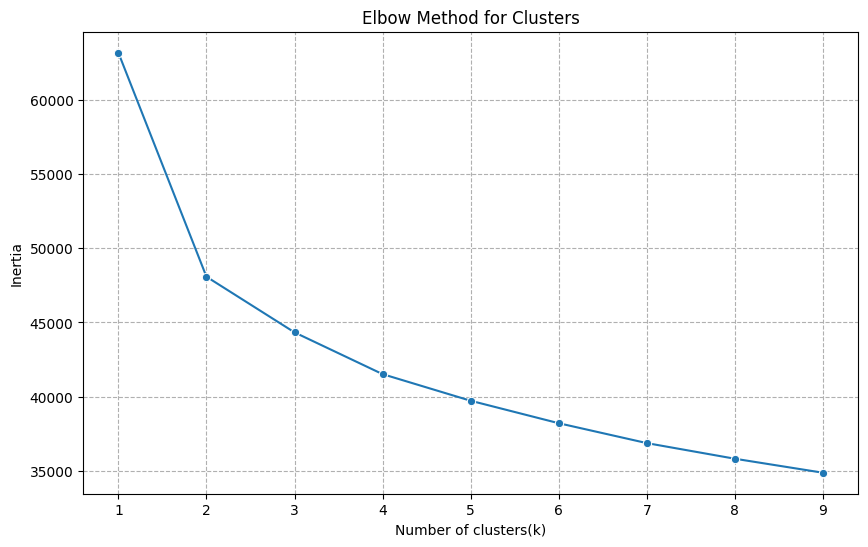

In [27]:
# Plot creation of elbow curve for determining optimal K value
elbow_fig, elbow_ax = plt.subplots(figsize=(10,6))

sns.lineplot(
    x=k,
    y=inertia_scores,
    ax=elbow_ax,
    marker="o",
)

elbow_ax.set_xlabel("Number of clusters(k)")
elbow_ax.set_ylabel("Inertia")
elbow_ax.set_title("Elbow Method for Clusters")
elbow_ax.grid(True, linestyle="--")

In [28]:
# Clustering through K means after identification of Optimal K(4) 
best_k = 4
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
clusters = kmeans.fit_predict(county_data_scaled)

# Storing of clusters in a DataFrame for Analysis with index for identification of counties
cluster_df = pd.DataFrame({"cluster": clusters},index = county_data_scaled.index)

In [29]:
# Combination of clusters with scaled information in order to better understand cluster analysis
combined_df = county_data_scaled.join(cluster_df)

In [30]:
# Checking distribution of counties in clusters
print("Counties by Cluster:")
combined_df["cluster"].value_counts().sort_index()

Counties by Cluster:


cluster
0     471
1     704
2    1104
3     880
Name: count, dtype: int64

In [31]:
# Reducing features to 2 components for cluster graphing
pca = PCA(n_components=2)
scaled_pca = pca.fit_transform(county_data_scaled)

# Addition of PCA to the dataframe
combined_df["PCA1"] = scaled_pca[:,0]
combined_df["PCA2"] = scaled_pca[:,1]

In [32]:
# Extraction of weights that are influencing features in PCA components
loadings = pd.DataFrame(pca.components_.T, index=county_data_scaled.columns,
                        columns=["PCA1","PCA2"])

# Identification of the 5 most influential features of PCA1
abs_loadings = loadings["PCA1"].abs().sort_values(ascending=False)
print("Features Strongly Influencing PCA1\n")
print(abs_loadings.head(5))

Features Strongly Influencing PCA1

% Fair or Poor Health                          0.349129
Average Number of Physically Unhealthy Days    0.338840
% Children in Poverty                          0.328247
% Some College                                 0.299532
% Completed High School                        0.297274
Name: PCA1, dtype: float64


In [33]:
# Identification of the 5 most influential features of PCA2
abs_loadings2 = loadings["PCA2"].abs().sort_values(ascending=False)
print("Features Strongly Influencing PCA2\n")
print(abs_loadings2.head(5))

Features Strongly Influencing PCA2

Mental Health Provider Rate                0.437334
% Severe Housing Problems                  0.407429
Dentist Rate                               0.402273
Primary Care Physicians Rate               0.375858
% With Access to Exercise Opportunities    0.313059
Name: PCA2, dtype: float64


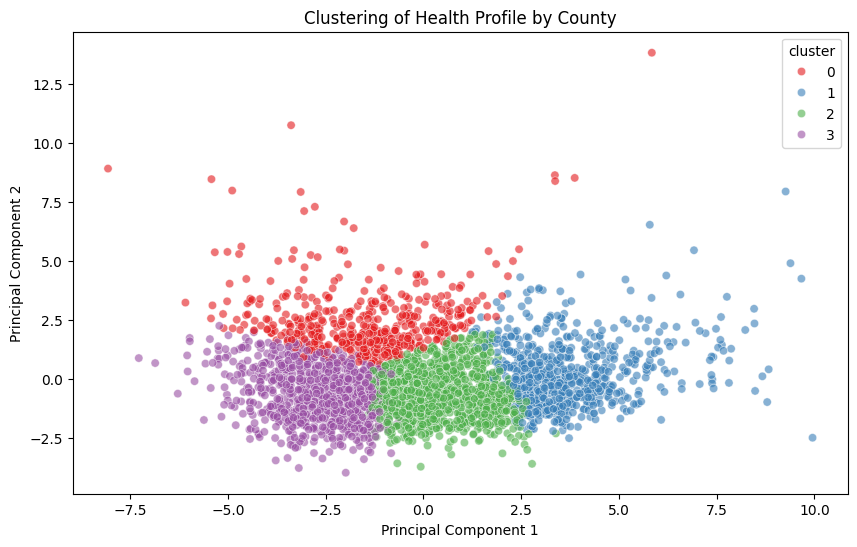

In [48]:
# Visualization of clusters based on PCA components
pca_fig, pca_ax = plt.subplots(figsize=(10,6))

plot = sns.scatterplot(
    data=combined_df,
    x = "PCA1",
    y = "PCA2",
    ax = pca_ax,
    hue = combined_df["cluster"],
    palette = "Set1",
    alpha=0.6
)

pca_ax.set_xlabel("Principal Component 1")
pca_ax.set_ylabel("Principal Component 2")
pca_ax.set_title("Clustering of Health Profile by County")

plt.show()

PCA Components:
- PCA1: This component is made up mostly of socioeconomic factors such as poor health, poverty and education. Moving further right on the X axis indicates that counties are doing worse with socioeconomic factors.
- PCA2: This component is composed of primarily healthcare providers such as mental health, doctors, and dentists. Moving up along the Y axis will typically indicate that the county has better access to healthcare providers.

Cluster 1 represents counties that require systemic intervention the most as they have limited access to care and poor socioeconmic factors.

# Analysis Part 2.2: Clustering Section 

In [35]:
# Combines cluster assignments to the scaled dataframe for analysis
county_data_scaled["cluster"] = combined_df["cluster"]

In [36]:
# Identification of 5 random counties from each cluster to inspect representative samples 
for cluster, subset in combined_df.groupby("cluster"):
    size = len(subset)
    print(f"\nCluster {cluster}: Size - {size}")

    take = min(5, size)
    state_in_cluster = np.random.choice(subset.index, size=take,replace=False)

    for state in state_in_cluster:
        print(" ", state)


Cluster 0: Size - 471
  Colorado: Larimer
  Virginia: Northampton
  Oregon: Clackamas
  Kentucky: Boyd
  Michigan: Charlevoix

Cluster 1: Size - 704
  Mississippi: Yazoo
  Virginia: Martinsville City
  Alabama: Russell
  Georgia: Ben Hill
  Texas: El Paso

Cluster 2: Size - 1104
  Georgia: Thomas
  Missouri: Montgomery
  Arkansas: Perry
  Kansas: Wyandotte
  Texas: Walker

Cluster 3: Size - 880
  New Jersey: Sussex
  Nebraska: Cedar
  North Dakota: Towner
  North Dakota: Grand Forks
  Utah: Sevier


In [37]:
# Manually aggregating feature means for each cluster to better understand group trends
data_df = {}
for cluster_id in combined_df["cluster"].unique():
    cluster_data = []
    for col in county_data_scaled.columns[:-1]:
        cluster_counties = combined_df[combined_df["cluster"] == cluster_id]
        cluster_avg = cluster_counties[col].mean()

        cluster_data.append(cluster_avg)

    data_df[cluster_id] = cluster_data


# Creation of table with cluster trends for each feature
cluster_mean_df = pd.DataFrame(data_df, index=county_data_scaled.columns[:-1])


In [38]:
cluster_mean_df.head(20)

,2,3,1,0
% Children in Poverty,-0.034579,-0.847417,1.324286,-0.315063
% Fair or Poor Health,0.081384,-0.939374,1.344895,-0.445872
% Low Birth Weight,-0.091203,-0.605123,0.936712,-0.055730
% With Access to Exercise Opportunities,-0.212995,0.211652,-0.587740,0.982296
% Long Commute - Drives Alone,0.230710,-0.230496,0.255262,-0.491661
% Uninsured,0.187694,-0.539840,0.636570,-0.382802
% Completed High School,-0.101949,0.797833,-1.132000,0.440310
% Some College,-0.341429,0.815084,-0.996837,0.767383
% Severe Housing Problems,-0.227989,-0.490491,0.350816,0.926448
% Unemployed,0.060969,-0.680576,0.660143,0.141945


In [39]:
def cluster_tables(df):
    """
    Creates cluster tables to identify the most significant features in each cluster.
    Values are changed to absolute but labeled negative to understand magnitude. 
    """
    cluster_results = {}

    for cluster in df.columns:
        rows = []

        for index, row_val in df[cluster].items():
            absolute_value = abs(row_val)

            # Adds a negative for values less than 0 to preserve magnitude when analyzing info
            if row_val < 0:
                label = f"{index} (neg)"
            else:
                label = index

            rows.append({
            "Label": label,
            "Value": absolute_value
            })

        cluster_profile_df = pd.DataFrame(rows).sort_values(by="Value",ascending = False).reset_index(drop=True)

        cluster_results[cluster] = cluster_profile_df

    return cluster_results

table = cluster_tables(cluster_mean_df.head())

for num in range(0,4):
    print(f"Cluster {num} Info")
    
    print(f"{table[num]}\n")
    

Cluster 0 Info
                                     Label     Value
0  % With Access to Exercise Opportunities  0.982296
1      % Long Commute - Drives Alone (neg)  0.491661
2              % Fair or Poor Health (neg)  0.445872
3              % Children in Poverty (neg)  0.315063
4                 % Low Birth Weight (neg)  0.055730

Cluster 1 Info
                                           Label     Value
0                          % Fair or Poor Health  1.344895
1                          % Children in Poverty  1.324286
2                             % Low Birth Weight  0.936712
3  % With Access to Exercise Opportunities (neg)  0.587740
4                  % Long Commute - Drives Alone  0.255262

Cluster 2 Info
                                           Label     Value
0                  % Long Commute - Drives Alone  0.230710
1  % With Access to Exercise Opportunities (neg)  0.212995
2                       % Low Birth Weight (neg)  0.091203
3                          % Fair or Poor Hea

Analysis of Clusters:
Negative in this study does not necessarily mean underperformance. It is feature dependent as negative fair or poor health actually means that the counties in this cluster have better health compared to other clusters.
- Cluster 0 (Above Average Counties): This cluster is composed of counties are performing better than the national average on important health factors. They tend to have better health and access to health
- Cluster 1 (Counties That Need the Most Intervention): This cluster is composed of counties facing the most difficulties as they have higher amounts of poor health and access.
- Cluster 2 (Average Counties): This cluster represents counties that are close to 0 in most factors showing they are the baseline.
- Cluster 3 (Counties Doing the Best): This cluster consists of counties that are doing the best overall with health factors.

# Analysis Part 3: Probability Section

For this section I will identify probability of a county belonging to a cluster by comparing its similarities to the centroid of each cluster. These similarities will be assessed based on distinct health categories. This analysis will be able to provide greater insight on the specific measures that influence the formations of the clusters. 

In [40]:
# Creating categorization for analysis of different health categories

health_cat = {
    "Quality of Life": [
        "% Fair or Poor Health",
        "% Low Birth Weight",
        "Average Number of Physically Unhealthy Days",
        "Average Number of Mentally Unhealthy Days",
    ],

    "Health Behaviors": [
        "% With Access to Exercise Opportunities",
        "Food Environment Index",
    ],

    "Clinical Care":[
        "Primary Care Physicians Rate",
        "Dentist Rate",
        "Mental Health Provider Rate",
    ],

    "Social and Economic Factors": [
        "% Completed High School",
        "% Some College",
        "% Severe Housing Problems",
        "% Unemployed",
        "% Children in Poverty",
        "Income Ratio",
    ],

    "Physical Environment": [
        "Average Daily PM2.5",
        "Presence of Water Violation",
        "% Long Commute - Drives Alone",
    ]
}


In [41]:
def cluster_by_cat(county_df, cluster_df, county_name,category,list_of_categories):
    """
    Calculates the probability a county belongs to a cluster depending on 
    health categories.
    """
    cluster_scores = {}
    
    analyzed_cat = list_of_categories[category]
    county_values = county_df.loc[county_name, analyzed_cat]

    # Gets the centroids for each cluster and compares them
    for cluster in cluster_df.columns:
        cluster_values = cluster_df.loc[analyzed_cat,cluster]
        difference = (county_values - cluster_values).abs().sum()
        score = 1 / (1 + difference)
        cluster_scores[cluster] = score

    # Normalizes similarity scores into a percentage
    total_score = sum(cluster_scores.values())
    probs = {cid: score / total_score for cid,score in cluster_scores.items()}


    return pd.Series(probs)
    

In [42]:
# Identifying clusters counties belong to before assesing probability based on health categories
counties = ["Louisiana: Franklin","California: Fresno","North Carolina: Robeson"]
for county in counties:
    cluster_id = county_data_scaled.loc[county, "cluster"]
    print(f"{county} is in Cluster {cluster_id}")

Louisiana: Franklin is in Cluster 1
California: Fresno is in Cluster 0
North Carolina: Robeson is in Cluster 1


In [43]:
def heatmap_for_county(county_name, county_df=county_data_scaled,cluster_df=cluster_mean_df,categories_dict=health_cat):
    """
    Function creates a similarity heatmap to identify a county belonging to a cluster based on health categories
    """
    probability_data = {}
    
    # Iterates through health categories to calculate similarity to all clusters
    for keys in health_cat.keys():
        probs = cluster_by_cat(
            county_df=county_df, 
            cluster_df = cluster_df,
            county_name=county_name,
            category=keys,
            list_of_categories=categories_dict
                  )
        probability_data[keys] = probs
    
    probability_df = pd.DataFrame(probability_data).T
    probability_df = probability_df[sorted(probability_df.columns)]
    
    # Creation of heatmap for identification of probability distribution
    heatmap_fig, heatmap_ax = plt.subplots(figsize=(12,8))
    
    sns.heatmap(
        probability_df,
        annot = True,
        fmt=".2f",
        cmap="coolwarm",
        ax=heatmap_ax
    )
    
    heatmap_ax.set_xlabel("Clusters")
    heatmap_ax.set_ylabel("Health Categories")
    heatmap_ax.set_title(f"Probability of {county_name} Belonging to Cluster Based on Health Categories")


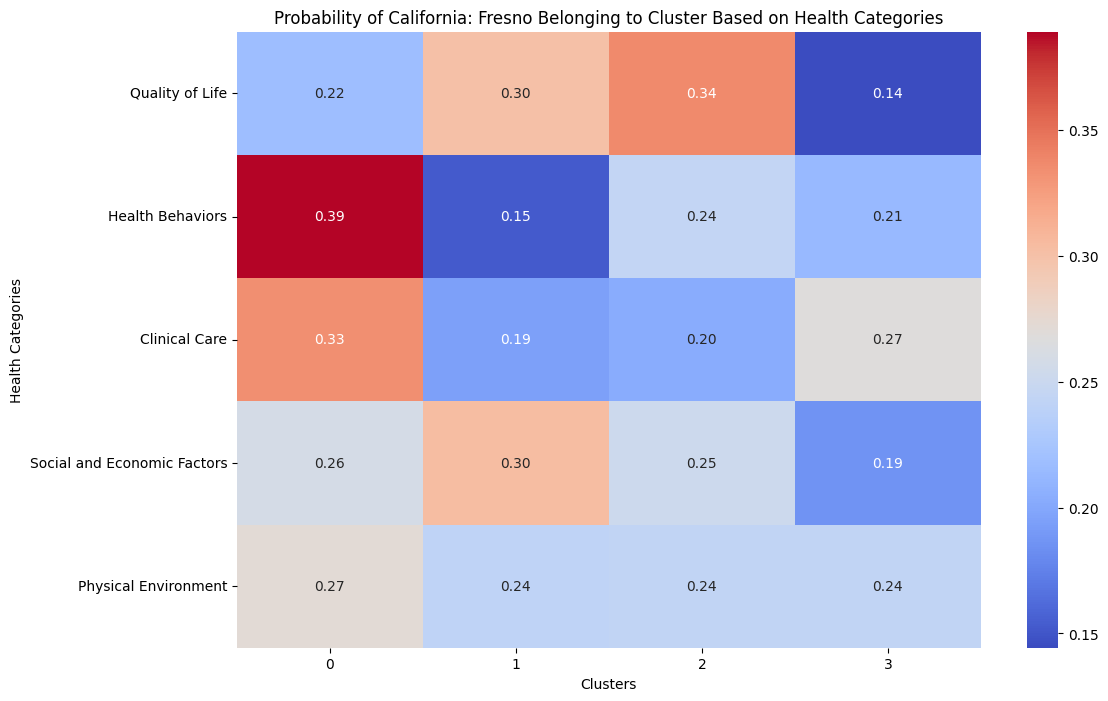

In [44]:
heatmap_for_county("California: Fresno")

For most categories Fresno California best alligns with cluster 0. This is accurate when compared to earlier cluster assessment. Health Behaviors and clinical care are the categories with the most influence causing it to align to that cluster.

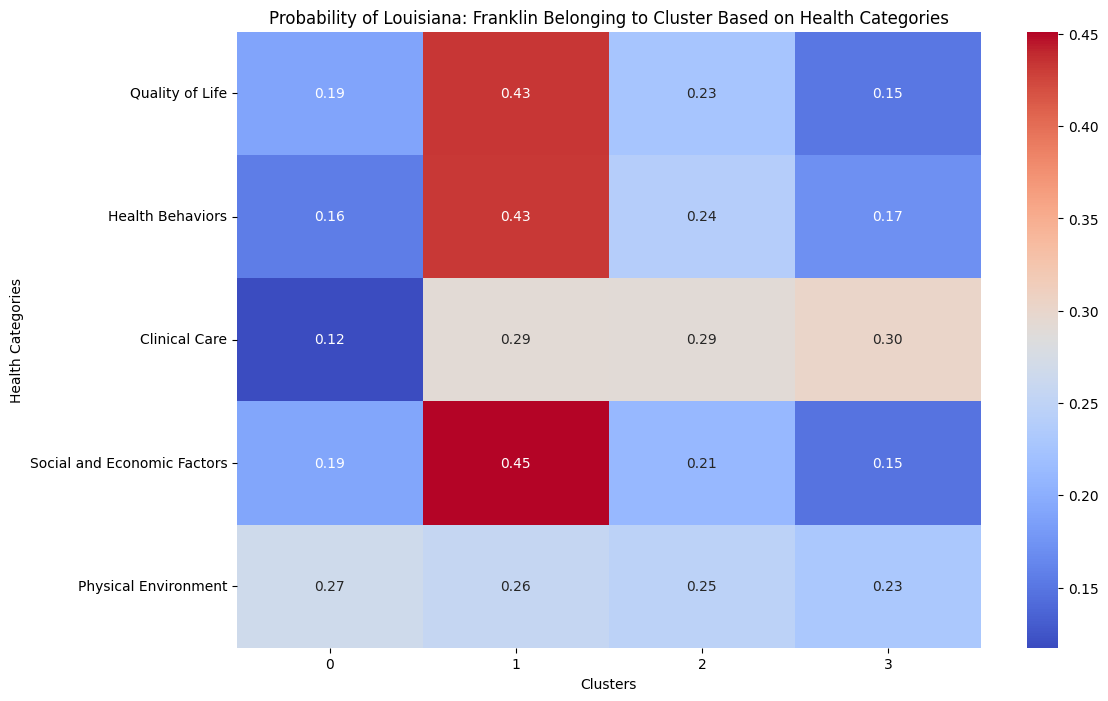

In [45]:
heatmap_for_county("Louisiana: Franklin")

Franklin Lousiana aligns most with health categories in cluster 1. It contains the highest probability for 3 seperate categories and does not strongly align with any other cluster. This showcases the 3 categories that are most problematic in cluster 1 rather than focusing on every individual feature.

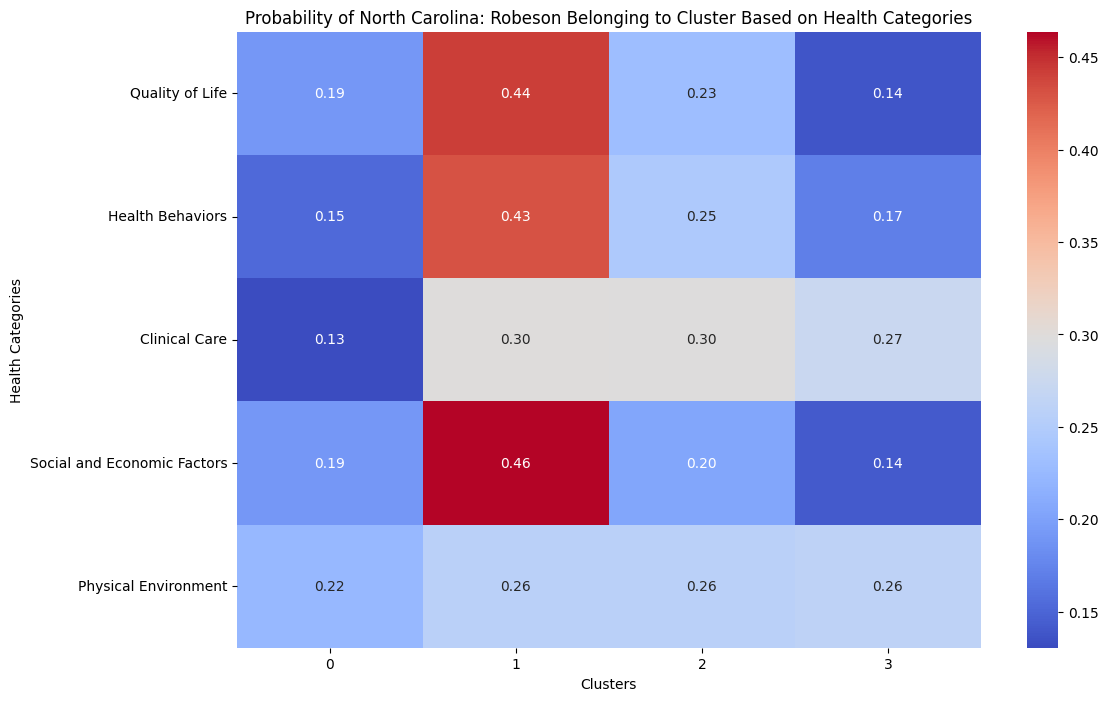

In [46]:
heatmap_for_county("North Carolina: Robeson")

Robeson in North Carolina closely aligns with cluster 1 based on the categories Quality of Life, Health Behaviors and Social and Economic Factors. In an earlier assessment it was assigned to cluster 1 making this an expected outcome.

# Conclusion

After completing cosine similarity, PCA clustering and probability assessments for health profiles of counties this analysis reveals that counties do not just group based on state boundaries. Instead, counties across the United State share similarities in health profiles. This shows that while counties are impacted by regional health factors, they are also impacted by systematic challenges. Clustering highlighted which clusters for counties are doing worse and require more immediate attention with clusters 1 and 2. Probability analysis gave insight on how counties align with clusters based on specific health categories instead of complete profiles. This highlights that even counties within the same cluster do not will require some personalized intervention. When the federal government is developing solutions for counties it is important to take into account local issues for a more personalized solution. However it is also equally as important to not ignore nation wide issues that are affecting a large amount of counties as highlighted by clusters.

Link to medium post with detailed descriptions https://medium.com/@josuea1/identifying-u-s-counties-based-on-similar-health-profiles-2a5020af5414